## Goals:

**1. Determine the primary drivers of sentiment in the flavor text of Magic: The Gathering cards.**

**2. Develop a model to predict the sentiment of flavor text in Magic: The Gathering cards.**

In [1]:
# imports and display options

import pandas as pd
import numpy as np
import math

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import prepare as p

pd.set_option('display.max_colwidth', -1)

# Acquire

* A CSV, containing an up to date breakdown of each Magic card that has been printed so far, was obtained from MTGJSON.com. 
* Each row represented a card or a version of a card.The dataframe contained 50,412 rows and 71 columns.
* The CSV was read into a pandas dataframe

# Prepare

The following steps were taken to prepare the data:

1. Data frame was restricted to relevant columns
 
2. Restricted dataframe to only rows containing cards that exist in physical form

3. Restricted dataframe to only row containing a flavor text

4. Restricted dataframe to only rows with a single color-identity

5. Merged rows with similar or overlapping types into one of the seven major game types

6. Restricted dataframe to include only rows with a single type belonging to one of the major game types

7. Cleaned up flavor text then aggregated on flavorText in an attempt to eliminate duplicates. This gave some success. However, it is likely that a few duplicates remain.

8. Reordered columns

9. Dropped rows where the flavor text was not in english 

10. Dropped rows with duplicates I happened to spot

11. Added sentiment column showing compound sentiment score using VADER

12. Added intensity column showing the absolute value of the compound sentiment score 

13. Renamed columns

14. Rounded number values in the data frame to two decimals	

Prepared data was then written to ‘mtgprep.csv’


### Worth Noting:
Typically, at the end of the preparation step, data would be divided into a test and train group to avoid overfitting the resulting model. In this study, our sample includes every applicable card that has been printed until now. This puts us in the unique position of having a sample size that is identical to its population size. It is therefore not be possible for the model to be overfit. For this reason, I have elected not to split the data.



In [2]:
# load and prepare data
df = p.get_mtg_data()

df.head()

,color,type,cost,rarity,flavor,sentiment,intensity
0,Green,Creature,5.0,common,""" . . . And the third little boar built his house out of rootwalla plates . . . .""",0.0,0.0
1,Black,Creature,1.0,common,""" . . . Cao Pi, Cao Rui, Fang, Mao, and briefly, Huan— The Sima took the empire in their turn. . . .""",0.0,0.0
2,Blue,Creature,5.0,uncommon,""" . . . When the trees bow down their heads, The wind is passing by.""",0.0,0.0
3,White,Creature,4.0,uncommon,""" . . . and you must also apply for an application license, file documents 136(iv) and 22-C and -D in triplicate, pay all requisite fees, request a . . .""",-0.1,0.1
4,Green,Creature,4.0,common,"""'Air superiority?' Not while our archers scan the skies.""",0.0,0.0


## Data Dictionary:

1. Magic: The Gatherin
    * a collectable card game developed by Wizards of the Coast Inc. In a typical game, each player combines a selection of cards from their collection into his or her own deck, which they use to compete against other players. Thematically, players assume the roles of powerful mages fighting for supremacy. Cards in each players deck represent spells and other resources each player’s disposal. A game typically ends when all but one of the participating players is reduced to zero “life” or is otherwise eliminated from the game.

### Columns

2. Color
    * Spells players can cast are divided into five different colors. Each color is thematically distinct. 
    * White represents order and morality. 
    * Blue represents cunning and technology.
    * Black represents pragmatism, and amorality. 
    * Red represents impulse and chaos. 
    * Green represents nature and instinct.
    <br /> 
    

3. Type
    * Spells player can cast are also divided by type: a spells type is the kind of effect that the spell has. 
    * Creatures represent ‘living’ beings that players summon to fight on their behalf. 
    * Artifacts represent powerful items that players can use to various effects. 
    * Enchantments represent players ability to augment the battlefield as well as things on the battlefield.
    * Instants and sorceries represent immediate and short-lived effects, such as throwing a fire ball. Instants are considered ‘faster’ than sorceries because they can be played on another player’s turn.
    * Planeswalkers represent other powerful mages the player has called to aid him or her.
    * Lands are not considered spells. they are where a player gathers ‘mana,’ the games resource used for casting spells. Different lands produce mana of different color, colors, or no color. 
    <br />  
    

4. Cost
    * The cost of the spell represents the amount of ‘mana,’ the games spell casting resource a player has to spend in order to cast that spell.
     <br />  
     

5. Rarity
    * When opening a standard booster pack of Magic: the Gathering cards players receive ten common cards, three uncommon cards, and one rare card
    * 1 in 8 packs will contain a mythic rare instead of a rare
     <br />   
     

6. Flavor
    * shows the flavor text of the card 
    * this text has no mechanical effect on games, but serve to reinforce the games themes and thus add “flavor” to the card
     <br />   
     

7. Sentiment 
    * shows the compound sentiment score for the corresponding flavor text 
    * using the vader sentiment analyser
     <br />   
     

8. Intensity
    * shows the intensity of the corresponding flavor text, disregarding if it is positive or negative
    * calculated by taking the absolute value of the sentiment score for the corresponding flavor text
     <br />   
     

# Explore

### Hypothesis/Initial Thoughts

I believe that color will be the most significant driver of sentiment, as it is the aspect of a card that seems most tied to the game’s them. The themes white is associated with seem to have a greater propensity for positive sentiment than do the themes black is associated with, which seem to have a greater propensity for negative sentiment. Another possibility is that cards with higher cost (and thus more dramatic effects on the game) will have a higher intensity. Although I do not know if it will be positive or negative. Aside from that, I am unsure what effect the other features might have. I do expect to see some difference, but I do not yet know what that will be.

### What does the data look like?

The fully prepared data frame contains:

1. 12,448 rows and 7 columns
    * There are about 20,000 cards in circulation, so 12,488 that remain after preparation represent a good sample of the available cards
2. four features representing how the card is categorized (datatype object)
3. one feature representing Mana cost of the card (datatype float64)


In [3]:
df.shape

(12448, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12448 entries, 0 to 12447
Data columns (total 7 columns):
color        12448 non-null object
type         12448 non-null object
cost         12448 non-null float64
rarity       12448 non-null object
flavor       12448 non-null object
sentiment    12448 non-null float64
intensity    12448 non-null float64
dtypes: float64(3), object(4)
memory usage: 680.9+ KB


### Observations:

1. mean sentiment in slightly negative at -.02, however it is very close to zero
2. median sentiment is 0 

3. mean intensity is .32 
4. median intensity is .32 

This suggests that both sentiment and intensity are normally distributed.

### Additional Hypothesis: 
It is possible that there are a large amount of cards that have a sentiment score of 0 . If this is true, and if the cards that had a positive score were normally distributed around .32 and the negative ones around -.32 that would explain these numbers. it would also explain the large standard deviation .42 in sentiment.

### observations:

1. sentiment scores ranged from -.98 to .95
2. intensity scores ranged from 0 to .98

This suggests the flavor text covers a wide range of sentimint values. 

In [5]:
df.describe()

,cost,sentiment,intensity
count,12448.00000,12448.000000,12448.000000
mean,3.17541,-0.024446,0.321163
std,1.61158,0.423125,0.276547
min,0.00000,-0.980000,0.000000
25%,2.00000,-0.340000,0.000000
50%,3.00000,0.000000,0.320000
75%,4.00000,0.300000,0.540000
max,15.00000,0.950000,0.980000


### How balanced are the features in  the data set?

* Color counts are about even
* types are very unevenly distributed Creature is the largest with 6978 and Planeswalker is the smallest with 1
* Cost appears normally distributed around 3
* rarity is unevenly distributed with common being the largest with 5927 and mythic being the smallest at 163 


In [6]:
for column in df.columns:
    
    if column not in ('sentiment','flavor'):
        print(f'{column} value counts')
        print(df[f'{column}'].value_counts())
        print('')

color value counts
Red      2562
White    2557
Black    2473
Green    2453
Blue     2403
Name: color, dtype: int64

type value counts
Creature        6978
Instant         2016
Sorcery         1762
Enchantment     1573
Land            77  
Artifact        41  
Planeswalker    1   
Name: type, dtype: int64

cost value counts
3.0     3037
2.0     2882
4.0     2289
1.0     1734
5.0     1397
6.0     645 
7.0     244 
8.0     90  
0.0     80  
9.0     29  
10.0    11  
11.0    5   
12.0    2   
15.0    1   
14.0    1   
0.5     1   
Name: cost, dtype: int64

rarity value counts
common      5926
uncommon    3644
rare        2715
mythic      163 
Name: rarity, dtype: int64

intensity value counts
0.00    3588
0.44    344 
0.30    326 
0.36    320 
0.38    298 
       ...  
0.94    8   
0.07    5   
0.95    5   
0.96    2   
0.98    1   
Name: intensity, Length: 98, dtype: int64



### How many cards have a sentiment/intensity score of zero?

* 0 is the most frequently occurring value (count = 3588)

* -.3 is second (count = 253)

* .44 is third (count =253)

In [7]:
df.sentiment.value_counts().head(10)

 0.00    3588
-0.30    253 
 0.44    214 
 0.36    213 
 0.49    165 
-0.38    164 
-0.34    160 
-0.60    157 
 0.42    145 
-0.48    134 
Name: sentiment, dtype: int64

### What is frequency distribution of sentiment scores?

* The distribution of positive negitive and zero sentiment scores appears to be about even.
* There are slightly more negative sentiment scores in the data set.
* Looking at the frquency distributions it appears that the hypothysis is correct. 
* Taken by themselves, positive and negative sentiment cards appear to be somewhat normally distributed. 
* When viewed as a whole the data set are not at all normally distributed.

In [8]:
print("Positive and Negative Sentiment Scores")
print('')

positive = df[df.sentiment>0].sentiment.count()
negative = df[df.sentiment<0].sentiment.count()
zero = df[df.sentiment==0].sentiment.count()
    
total = df.sentiment.count()
      
    
print(f'Positive: {round(positive/total,2)}%  Negative: {round(negative/total,2)}%  Zero: {round(zero/total,2)}%')

Positive and Negative Sentiment Scores

Positive: 0.34%  Negative: 0.38%  Zero: 0.29%


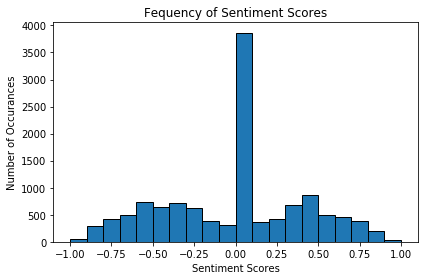

In [9]:
bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



sentiment = df['sentiment']

plt.hist(sentiment,bins=bins,edgecolor='black')


plt.title('Fequency of Sentiment Scores')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

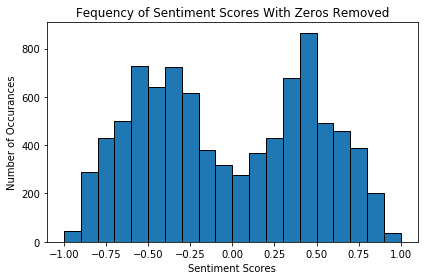

In [10]:
bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



sentiment = df.sentiment[df.sentiment!=0]

plt.hist(sentiment,bins=bins,edgecolor='black')


plt.title('Fequency of Sentiment Scores With Zeros Removed')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

### What is frequency distribution of intensity scores?

* The most frequent intensity score is 0. 
* Intensity scores with a non-zero value seem to be normally distributed around .4.

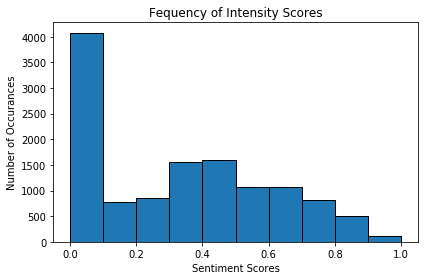

In [11]:
bins =[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



intensity = df['intensity']

plt.hist(intensity,bins=bins,edgecolor='black')


plt.title('Fequency of Intensity Scores')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

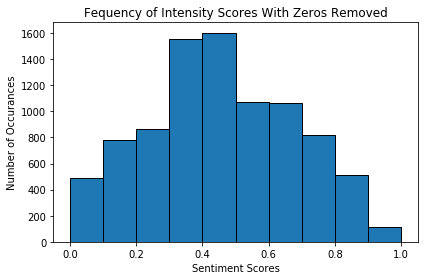

In [12]:
bins =[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



intensity = df.intensity[df.intensity!=0]

plt.hist(intensity,bins=bins,edgecolor='black')


plt.title('Fequency of Intensity Scores With Zeros Removed')
plt.xlabel('Sentiment Scores')
plt.ylabel('Number of Occurances')





plt.tight_layout()

plt.show()

### What do high, low, and zero sentiment flavor texts look like?

* Highest Sentiment flavor text is: Some spectators love an underdog, but others are just as happy to support a proven winner.	

* Lowest sentiment flavor text is: "We mourn our dead. We shroud our dead. We bury our dead. Too often, it seems, we must kill our dead again."

* A zero-sentiment flavor text is: " . . . And the third little boar built his house out of rootwalla plates . . . ."


In [13]:
df[['flavor','sentiment']].sort_values('sentiment',ascending=False).head()

,flavor,sentiment
9885,"Some spectators love an underdog, but others are just as happy to support a proven winner.",0.95
8848,"MORE TO LOVE: Friendly, nature-loving, Bunyonesque SEM seeks SEF looking for a huge commitment. . . . seeks atog prince",0.94
3853,"""The aven are heralds of divinity. The greatest glory is to join them in the sky.""",0.93
5313,"""When I wish to be strong, I train. When I wish to be wise, I study. When I wish to rest, I start again.""",0.93
11771,"To become an officer, an Icatian Soldier had to pass a series of tests. These evaluated not only fighting and leadership skills, but also integrity, honor, and moral strength.",0.93


In [14]:
df[['flavor','sentiment']].sort_values('sentiment',ascending=True).head()

,flavor,sentiment
5112,"""We mourn our dead. We shroud our dead. We bury our dead. Too often, it seems, we must kill our dead again.""",-0.98
9133,"No one spoke. There was no need. The threat of the Eldrazi presented a simple choice: lay down your weapons and die for nothing, or hold them fast and die for something.",-0.96
2943,"""No more fear. No more failure. No more death. No more!""",-0.96
2434,"""Kill a creature, destroy the present. Kill the land, destroy the future.""",-0.95
11430,"There are laws against it, but the dead have no one to complain to and the living are too frightened to investigate.",-0.95


In [15]:
df[['flavor','sentiment']][df.sentiment==0].head(10)

,flavor,sentiment
0,""" . . . And the third little boar built his house out of rootwalla plates . . . .""",0.0
1,""" . . . Cao Pi, Cao Rui, Fang, Mao, and briefly, Huan— The Sima took the empire in their turn. . . .""",0.0
2,""" . . . When the trees bow down their heads, The wind is passing by.""",0.0
4,"""'Air superiority?' Not while our archers scan the skies.""",0.0
9,"""'I have arrived,' bellowed Brawn, and the plane shuddered.""",0.0
10,"""'I'll show you how to handle the treefolk!' the giant bragged, and he strode off into the forest. Two days later he returned, his face masked in sap and a nest behind his ear. None dared ask who won.""",0.0
12,"""'I've seen hornworms big as a man's fist,' the traveler said, and nodded soberly when our jaws went slack at his ignorance.""",0.0
13,"""'Invincible' is just a word.""",0.0
16,"""'Ownership' is such a gray area.""",0.0
19,"""'Tis distance lends enchantment to the view, And robes the mountain in its azure hue.""",0.0


### How does sentiment relate to each feature?

* Because of the shape of our data, stats tests to determine if features are related such as T-test and correlation or not usable for measuring sentiment.

### Color

* three colors have positive mean sentiment scores white, blue, and green
* two colors have negative mean scores black and red
* four colors have mean sentiment values that are less than .1 away from zero, white, blue, gree, red and green
* one color with the most extream mean sentiment score was black at -.12
* all colors have a mean and median sentiment score of 0
* between 24-34% of values for each color are zero
* frquency of negative positive and zero sentiment scores are fairly evenly distributed amoung colors. The most extream values are black with 48% negative and white with 41% positive

* looking at the frequency distribution of sentiment scores they seem to follow the same general distribution as the overall data.
* The most notable differance is that black has noticably more negative sentament scores than positive ones. This is reflected in its more extream than usual mean sentiment score.
* It is likely that color is a driver of sentiment however the effect of color on sentiment is not very high

In [16]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.mean()
      
    print(f'{color}: {round(number,2)}')

White: 0.03
Blue: 0.01
Black: -0.12
Red: -0.06
Green: 0.01


In [17]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.median()
      
    print(f'{color}: {number}')

White: 0.0
Blue: 0.0
Black: 0.0
Red: 0.0
Green: 0.0


In [18]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:

    number = df[df.color==f'{color}'].sentiment.mode()
      
    print(f'{color}: {number}')

White: 0    0.0
dtype: float64
Blue: 0    0.0
dtype: float64
Black: 0    0.0
dtype: float64
Red: 0    0.0
dtype: float64
Green: 0    0.0
dtype: float64


In [19]:
colors = ['White','Blue','Black','Red','Green']

print("Positive and Negative Sentiment Scores")

for color in colors:

    positive = df[df.color==f'{color}'][df.sentiment>0].sentiment.count()
    negative = df[df.color==f'{color}'][df.sentiment<0].sentiment.count()
    zero = df[df.color==f'{color}'][df.sentiment==0].sentiment.count()
    
    total = df[df.color==f'{color}'].sentiment.count()
      
    print('')
    print(f'{color}: Positive: {round(positive/total,2)}%  Negative: {round(negative/total,2)}%  Zero: {round(zero/total,2)}%')

Positive and Negative Sentiment Scores

White: Positive: 0.41%  Negative: 0.34%  Zero: 0.25%

Blue: Positive: 0.35%  Negative: 0.33%  Zero: 0.33%

Black: Positive: 0.28%  Negative: 0.48%  Zero: 0.24%

Red: Positive: 0.31%  Negative: 0.4%  Zero: 0.29%

Green: Positive: 0.34%  Negative: 0.32%  Zero: 0.34%


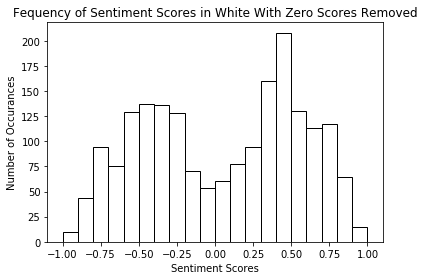

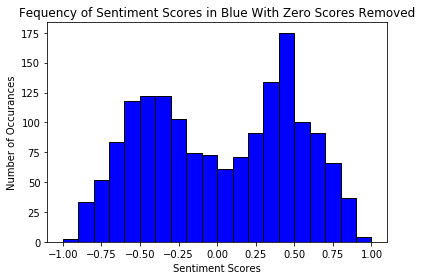

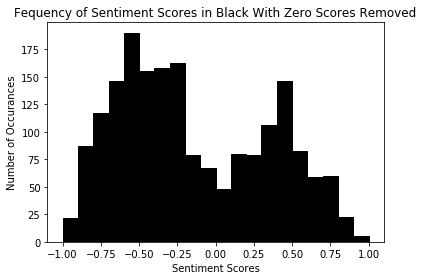

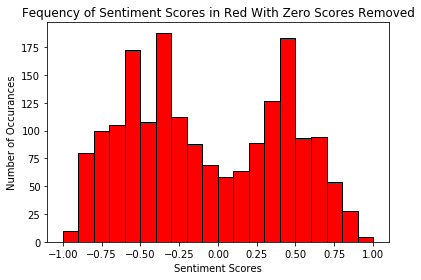

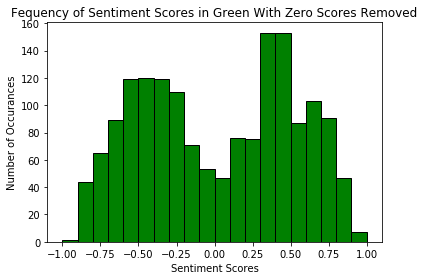

In [20]:
colors = ['White','Blue','Black','Red','Green']

for color in colors:


    bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]



    sentiment = df.sentiment[df.sentiment!=0][df.color==f'{color}']

    plt.hist(sentiment,bins=bins,edgecolor='black',color=f'{color}')


    plt.title(f'Fequency of Sentiment Scores in {color} With Zero Scores Removed')
    plt.xlabel('Sentiment Scores')
    plt.ylabel('Number of Occurances')





    plt.tight_layout()

    plt.show()

### Types

* types that have a large sample size closely mimic the data set as a whole
* Creatures, Instants, and sorcerys each have a mean sentiment of -.02 which is the same as the mean sentiment for the entire data set when rounded to two decimals
* Sorcery is also close with a value of -.04
* types with a lower sample size are more speratic 
* Lands have a mean sentiment of -.07, Artifacts have a .04, and Planeswalkers have a .58 (sample of one)
* Lands and Artifacts have a larger than normal amount of zero values, 46% and 58% respectively
* in seems that as the sample size gets smaller the data in the sample beomes less likely to mimic the over all data.
* looking at the distributions of sentament by type, types with larger sample sizes mimic the overall data, types that do not have a large sample size do not 
* It is not likely that type is a driver of sentiment

In [21]:
types = ['Creature','Instant','Sorcery','Enchantment','Land','Artifact','Planeswalker']

for item in types:

    number = df[df.types==f'{item}'].sentiment.mean()
      
    print(f'{item}: {round(number,2)}')

AttributeError: 'DataFrame' object has no attribute 'types'

In [ ]:
types = ['Creature','Instant','Sorcery','Enchantment','Land','Artifact','Planeswalker']

for item in types:

    number = df[df.types==f'{item}'].sentiment.median()
      
    print(f'{item}: {round(number,2)}')

In [ ]:
types = ['Creature','Instant','Sorcery','Enchantment','Land','Artifact','Planeswalker']

for item in types:

    number = df[df.types==f'{item}'].sentiment.mode()
      
    print(f'{item}: {round(number,2)}')

In [ ]:
types = ['Creature','Instant','Sorcery','Enchantment','Land','Artifact','Planeswalker']

print("Positive and Negative Sentiment Scores")

for item in types:

    positive = df[df.types==f'{item}'][df.sentiment>0].sentiment.count()
    negative = df[df.types==f'{item}'][df.sentiment<0].sentiment.count()
    zero = df[df.types==f'{item}'][df.sentiment==0].sentiment.count()
    
    total = df[df.types==f'{item}'].sentiment.count()
      
    print('')
    print(f'{item}: Positive: {round(positive/total,2)}%  Negative: {round(negative/total,2)}%  Zero: {round(zero/total,2)}%')

In [ ]:
types = ['Creature','Instant','Sorcery','Enchantment','Land','Artifact','Planeswalker']

for item in types:


    bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

    sentiment = df.sentiment[df.sentiment!=0][df.types==f'{item}']

    plt.hist(sentiment,bins=bins,edgecolor='black',color='firebrick')


    plt.title(f'Fequency of Sentiment Scores in {item} With Zero Scores Removed')
    plt.xlabel('Sentiment Scores')
    plt.ylabel('Number of Occurances')

    plt.tight_layout()

    plt.show()

### Rarity

* All rarity types have a mean sentiment that is very near the mean sentiment of the overall data ranging from -.01 to -.03 
* the frequency of positive, negative, and zero sentiment scores are remarkably evenly distributed at each rarity level
* The overall distribution of sentiment scores devided by rarity level mimics the overall data at each level
* It is not likely that rarity is a driver of sentiment

In [ ]:
scarcity = ['common','uncommon','rare','mythic']

for item in scarcity:

    number = df[df.rarity==f'{item}'].sentiment.mean()
      
    print(f'{item}: {round(number,2)}')

In [ ]:
scarcity = ['common','uncommon','rare','mythic']

for item in scarcity:

    number = df[df.rarity==f'{item}'].sentiment.median()
      
    print(f'{item}: {round(number,2)}')

In [ ]:
scarcity = ['common','uncommon','rare','mythic']

for item in scarcity:

    number = df[df.rarity==f'{item}'].sentiment.mode()
      
    print(f'{item}: {round(number,2)}')

In [ ]:
scarcity = ['common','uncommon','rare','mythic']

print("Positive and Negative Sentiment Scores")

for item in scarcity:

    positive = df[df.rarity==f'{item}'][df.sentiment>0].sentiment.count()
    negative = df[df.rarity==f'{item}'][df.sentiment<0].sentiment.count()
    zero = df[df.rarity==f'{item}'][df.sentiment==0].sentiment.count()
    
    total = df[df.rarity==f'{item}'].sentiment.count()
      
    print('')
    print(f'{item}: Positive: {round(positive/total,2)}%  Negative: {round(negative/total,2)}%  Zero: {round(zero/total,2)}%')

In [ ]:
scarcity = ['common','uncommon','rare','mythic']

for item in scarcity:


    bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

    sentiment = df.sentiment[df.sentiment!=0][df.rarity==f'{item}']

    plt.hist(sentiment,bins=bins,edgecolor='black',color='firebrick')


    plt.title(f'Fequency of Sentiment Scores in {item} With Zero Scores Removed')
    plt.xlabel('Sentiment Scores')
    plt.ylabel('Number of Occurances')

    plt.tight_layout()

    plt.show()

### Cost

* costs with large sample sizes have a mean sentiment score that is near that of the overall data
* costs with large sample sized also have a distribution of sentiment scores that closely mimics the overall data
* positive, negative, and zero sentiment scores are fairly even evenly distributed at cost levels that have high sample sizes
* worth noting cost of 10, 11, and 12, are the only divition of the data that has shown a median value other than zero. However, these cost levels represent only a small amount of data
* I do not believe that cost is a driver of sentiment

In [ ]:
df.cost.value_counts()

In [ ]:
for r in range(1,15):

    if r != 13:
   
        number = df[df.cost== r].sentiment.mean()
      
        print(f'{r}: {number}')

In [ ]:
for r in range(1,15):

    if r != 13:
   
        number = df[df.cost== r].sentiment.median()
      
        print(f'{r}: {number}')

In [ ]:
for r in range(1,15):

    if r != 13:
   
        number = df[df.cost== r].sentiment.mode()
      
        print(f'{r}: {number}')

In [ ]:
print("Positive and Negative Sentiment Scores")

for r in range(1,15):

    if r != 13:

        positive = df[df.cost==r][df.sentiment>0].sentiment.count()
        negative = df[df.cost==r][df.sentiment<0].sentiment.count()
        zero = df[df.cost==r][df.sentiment==0].sentiment.count()
    
        total = df[df.cost==r].sentiment.count()
      
        print('')
        print(f'{r}: Positive: {round(positive/total,2)}%  Negative: {round(negative/total,2)}%  Zero: {round(zero/total,2)}%')

In [ ]:
for r in range(1,15):

    if r not in (13,14):
        
        bins =[-1,-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]

        sentiment = df.sentiment[df.sentiment!=0][df.cost==r]

        plt.hist(sentiment,bins=bins,edgecolor='black',color='firebrick')


        plt.title(f'Fequency of Sentiment Scores in {r} With Zero Scores Removed')
        plt.xlabel('Sentiment Scores')
        plt.ylabel('Number of Occurances')

        plt.tight_layout()

        plt.show()

### Exploration Summary

* The only feature that seems to drive sentiment is color
* I will proceed to modeling using only that feature


# Modeling

1. create baseline using regression model using mean sentiment score
2. create regression model using color
3. compare results

In [ ]:
df['yhat'] = df.sentiment.mean()

In [ ]:
df['zero'] = 0

In [ ]:
df.head()

In [ ]:
yhat = df[['yhat']]

X = df[['color']]

y = df[['sentiment']]

In [ ]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from math import sqrt

lm1 = LinearRegression()
lm1.fit(yhat, y)

y_pred_baseline = np.array(yhat)
MSE = mean_squared_error(y, y_pred_baseline)
SSE = MSE*len(y)
RMSE = sqrt(MSE)

evs = explained_variance_score(y, y_pred_baseline)

print(f"Mean Squared Error: {MSE}")
print('')
print(f"Sum of Squared Errors: {SSE}")
print('')
print(f"Root Mean Square Errors: {RMSE}")
print('')
print(f"Explained Variance Score: {evs}")



In [ ]:
encoded_values = colors = ['Black','Blue','Green','Red','White']

# Integer Encoding
int_encoder = LabelEncoder()
X.encoded = int_encoder.fit_transform(X.color)

# create 2D np arrays of the encoded variable (in train and test)
X_array = np.array(X.encoded).reshape(len(X.encoded),1)

# One Hot Encoding
ohe = OneHotEncoder(sparse=False, categories='auto')
X_ohe = ohe.fit_transform(X_array)

# Turn the array of new values into a data frame with columns names being the values
# and index matching that of train/test
# then merge the new dataframe with the existing train/test dataframe
X_encoded = pd.DataFrame(data=X_ohe, columns=encoded_values, index=X.index)

X = X.join(X_encoded)

X 

In [ ]:
X.drop(columns='color',inplace=True)

In [ ]:
X

In [ ]:
from sklearn.metrics import mean_squared_error, explained_variance_score
from math import sqrt

lm1 = LinearRegression()
lm1.fit(X, y)

y_pred_color = lm1.predict(X)

MSE = mean_squared_error(y, y_pred_color)
SSE = MSE*len(y)
RMSE = sqrt(MSE)

evs = explained_variance_score(y, y_pred_color)

print(f"Mean Squared Error: {MSE}")
print('')
print(f"Sum of Squared Errors: {SSE}")
print('')
print(f"Root Mean Square Errors: {RMSE}")
print('')
print(f"Explained Variance Score: {round(evs,2)}")